# Omnigenity Optimization

This tutorial demonstrates how to optimize for omnigenity in DESC. Currently, DESC provides two optimization methods for Omnigenity: `Omnigenity` and `OmnigenityHarmonics`.

## Omnigenity
It will go through an example using `Omnigenity` method with poloidally closed contours of magnetic field strength (OP), but the method is capable of optimizing for any general omnigenous magnetic fields. The underlying theory and methodology are described in [Dudt et al. (2024)](https://doi.org/10.1017/S0022377824000151).

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [2]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from desc.backend import jnp
from desc.equilibrium import Equilibrium, EquilibriaFamily
from desc.continuation import solve_continuation_automatic
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.magnetic_fields import (
    OmnigenousField,
    OmnigenousFieldOOPS,
    OmnigenousFieldLCForm,
)
from desc.objectives import (
    AspectRatio,
    CurrentDensity,
    FixCurrent,
    FixOmniBmax,
    FixOmniMap,
    FixPressure,
    FixPsi,
    FixBoundaryR,
    FixBoundaryZ,
    GenericObjective,
    LinearObjectiveFromUser,
    ObjectiveFunction,
    MirrorRatio,
    Omnigenity,
    OmnigenityHarmonics,
    RotationalTransform,
    ForceBalance,
)
from desc.optimize import Optimizer
from desc.plotting import plot_boozer_surface, plot_boundaries

plt.rcParams["font.size"] = 14

ERROR:2025-09-08 20:22:40,849:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/hengqianliu/.conda/envs/desc_develop/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/hengqianliu/.conda/envs/desc_develop/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/hengqianliu/.conda/envs/desc_develop/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


As an initial guess for the optimization, we will start with a boundary shape generated by an analytic model for (very approximate) quasi-poloidal symmetry (QP). 
In this example, we will seek a vacuum magnetic field with two field periods ($N_{FP}=2$), an aspect ratio of $R_0/a\leq10$, and a mirror ratio on axis of $\Delta=0.2$. 

In [5]:
surf = FourierRZToroidalSurface.from_qp_model(
    major_radius=1,
    aspect_ratio=10,
    elongation=3,
    mirror_ratio=0.2,
    torsion=0.1,
    NFP=2,
    sym=True,
)
# this value of Psi gives an average |B| on axis of about 1 T
# the Equilibrium class defaults to vacuum pressure and current profiles
eq = Equilibrium(Psi=3e-2, M=4, N=4, surface=surf)

Now that the equilibrium is initialized, we need to solve the fixed-boundary vacuum equilibrium: 

In [6]:
eq, _ = eq.solve(objective="force", verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 748 ms
Timer: Objective build = 1.15 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 564 ms
Timer: LinearConstraintProjection build = 3.38 sec
Number of parameters: 120
Number of objectives: 850
Timer: Initializing the optimization = 5.15 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.143e-01                                    3.027e-01   
       1              2          3.126e-03      1.112e-01      1.372e-01

--------------------------------------------------------------------------
Let us make a copy of this initial equilibrium so that we can compare our final solution to it later and see how well the omnigenity optimization worked. 
By plotting the $|B|$ contours in Boozer coordinates, we can see that this equilibrium is already somewhat close to being omnigenous with poloidal contours, but far from perfect. 

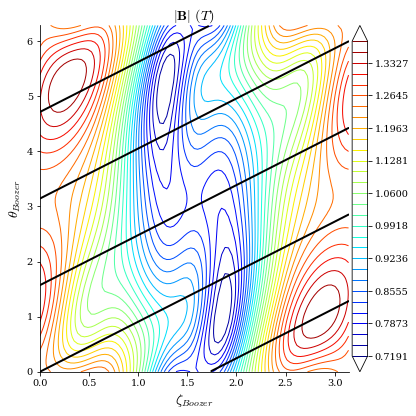

In [7]:
eq0 = eq.copy()
# defaults to the rho=1 surface
plot_boozer_surface(eq0, fieldlines=4);

In order to optimize the equilibrium for omnigenity, we need to create a target omnigenous magnetic field. 
The `OmnigenousField` class has two attributes that represent parameters in the omnigenous magnetic field model: 
- `B_lm` specifies the shape of the "magnetic well" on each flux surface. 
- `x_lmn` specifies how the well shape varies along different field lines. 

The helicity is given by the tuple of integers $(M, N)$, and is set to $(0, N_{FP})$ for omnigenity with poloidal contours in this example. 
The typical case for helical contours would be $(1, N_{FP})$, and for toroidal contours would be $(1, 0)$. 

We need to specify the resolution of the parameter space, given by the following integers: 
- `L_B` is the maximum power of $\rho$ used in the Chebyshev polynomial expansion for `B_lm`. 
- `M_B` is the number of spline knots used on each surface for `B_lm`. 
- `L_x` is the maximum power of $\rho$ used in the Chebyshev polynomial expansion for `x_lmn`. 
- `M_x` is the maximum mode number used in the cosine series expansion in $\eta$ for `x_lmn`. 
- `N_x` is the maximum mode number used in the Fourier series expansion in $\alpha$ for `x_lmn`. Quasi-symmetry corresponds to `N_x=0`. 

We provide initial values for the well shape parameters `B_lm` so that we can set the mirror ratio. 
The total number of parameters is `B_lm.size = M_B * (L_B + 1)`. 
In this example, the well shape on each surface is represented by three spline knots, and there is $\mathcal{O}(\rho)$ variation across the flux surfaces. 
Here we set only the constant terms of the Chebyshev polynomials such that the initial target field has the same magnetic well from $B_{\mathrm{min}}=0.8\mathrm{~T}$ to $B_{\mathrm{max}}=1.2\mathrm{~T}$ on each surface (corresponding to a mirror ratio of $\Delta=0.2$). 

The `x_lmn` parameters are left to their default values of 0, which corresponds to a quasi-poloidally symmetric (QP) initial target field. 
These parameters will not be fixed during the optimization, so the final result will not be constrained to QP symmetry. 


In [8]:
field = OmnigenousField(
    L_B=1,  # radial resolution of B_lm parameters
    M_B=3,  # number of spline knots on each flux surface
    L_x=1,  # radial resolution of x_lmn parameters
    M_x=1,  # eta resolution of x_lmn parameters
    N_x=1,  # alpha resolution of x_lmn parameters
    NFP=eq.NFP,  # number of field periods; should always be equal to Equilibrium.NFP
    helicity=(0, eq.NFP),  # helicity for poloidally closed |B| contours
    B_lm=np.array(  # magnetic well shape parameters
        [
            [0.8, 1.0, 1.2],  # the first M_well coefficients are the L_B=0 spline knots
            [0, 0, 0],
        ]  # the next M_well coefficients are the L_B=1 spline knots, etc.
    ).flatten(),
)
field0 = field.copy()

We can use the `field.compute` function to visualize what the current target well shape for this field is, with the minimum and maximum as we have prescribed. 
This magnetic well will be allowed to change during the optimization process according to how the `B_lm` coefficients change. 

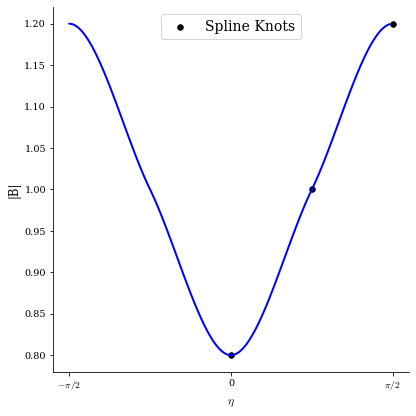

In [9]:
# plot initial target well |B|
grid_well = LinearGrid(rho=[0.0], M=50)
data_initial = field.compute("|B|", grid=grid_well)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(data_initial["eta"], data_initial["|B|"], c="b", lw=2)
ax.scatter(
    [0, np.pi / 4, np.pi / 2],
    field.B_lm[0 : field.M_B] - field.B_lm[field.M_B :],
    c="k",
    marker=".",
    label="Spline Knots",
    s=120,
)
ax.set_xticks([-np.pi / 2, 0, np.pi / 2])
ax.set_xticklabels(["$-\\pi/2$", "0", "$\\pi/2$"])
ax.set_xlabel("$\\eta$")
ax.set_ylabel("|B|")
ax.legend(loc="upper center");

Next we create the objective function for the optimization. 
We include one objective to keep the major radius at $R_0=1~m$, and another to keep the aspect ratio at $R_0/a\leq10$. 
The elongation will be unconstrained, but that is another common objective we could choose to include. 

We will also target omnigenity on two flux surfaces: $\rho=0.5$ and $\rho=1$. 
The `Omnigenity` objective class requires two different computational grids: 
- `eq_grid` is the grid used to compute the Boozer transform. 
- `field_grid` is the grid corresponding to $(\rho,\eta,\alpha)$ coordinates where the omnigenity residuals are minimized. 

A separate `Omnigenity` objective is required for each flux surface, but they all reference the same `Equilibrium` and `OmnigenousField`. Make sure both grids for each objective are at the desired surface and have `sym=False`! 

In [10]:
eq_half_grid = LinearGrid(rho=0.5, M=4 * eq.M, N=4 * eq.N, NFP=eq.NFP, sym=False)
eq_lcfs_grid = LinearGrid(rho=1.0, M=4 * eq.M, N=4 * eq.N, NFP=eq.NFP, sym=False)

field_half_grid = LinearGrid(rho=0.5, theta=16, zeta=8, NFP=field.NFP, sym=False)
field_lcfs_grid = LinearGrid(rho=1.0, theta=16, zeta=8, NFP=field.NFP, sym=False)

objective = ObjectiveFunction(
    (
        # target major radius of R0=1 m
        GenericObjective("R0", thing=eq, target=1.0, name="major radius"),
        # target aspect ratio R0/a<=10
        AspectRatio(eq=eq, bounds=(0, 10)),
        # omnigenity on the rho=0.5 surface
        Omnigenity(
            eq=eq,
            field=field,
            eq_grid=eq_half_grid,
            field_grid=field_half_grid,
            eta_weight=1,
        ),
        # omnigenity on the rho=1.0 surface
        Omnigenity(
            eq=eq,
            field=field,
            eq_grid=eq_lcfs_grid,
            field_grid=field_lcfs_grid,
            eta_weight=2,
        ),
    )
)

Next we set the optimization constraints. 
The `CurrentDensity`, `FixPressure`, `FixCurrent`, and `FixPsi` objectives ensure that we maintain a good vacuum equilibrium during the optimization. 

We also include three additional constraints that are unique to the omnigenity optimization: 
- A perfect omnigenous magnetic field must have a straight $B_{\mathrm{max}}$ contour in Boozer coordinates, and this is accomplished with the `FixOmniBmax` objective. 
- The `FixOmniMap` objective is used to fix values of the `field.x_lmn` parameters. 
In this OP example our $B_{\mathrm{max}}$ contour is located at $\zeta_B=0$, and this constraint is used to ensure that the $B_{\mathrm{min}}$ contour is located at $\zeta_B=\pi/N_{FP}$ on average. 
This constraint should always be true for stellarator symmetry. 
- The `LinearObjectiveFromUser` objective is used to fix the sum of values of the `field.B_lm` parameters. 
Here we use it to fix the values of $B_{\mathrm{min}}$ and $B_{\mathrm{max}}$ on axis to contrain the mirror ratio. 
The shape of the magnetic well will still have one degree of freedom on the magnetic axis, and the mirror ratio is unconstrained on other flux surfaces. 

In [11]:
def mirrorRatio(params):
    """Custom linear function to constrain the mirror ratio on axis."""
    B_lm = params["B_lm"]
    f = jnp.array(
        [
            B_lm[0] - B_lm[field.M_B],  # B_min on axis
            B_lm[field.M_B - 1] - B_lm[-1],  # B_max on axis
        ]
    )
    return f


constraints = (
    CurrentDensity(eq=eq),  # vacuum equilibrium force balance
    FixPressure(eq=eq),  # fix vacuum pressure profile
    FixCurrent(eq=eq),  # fix vacuum current profile
    FixPsi(eq=eq),  # fix total toroidal magnetic flux
    # ensure the B_max contour is straight in Boozer coordinates
    FixOmniBmax(field=field),
    # ensure the average B_min contour is at zeta_B=pi/NFP
    FixOmniMap(field=field, indices=np.where(field.x_basis.modes[:, 1] == 0)[0]),
    # fix the mirror ratio on the magnetic axis
    LinearObjectiveFromUser(mirrorRatio, field, target=[0.8, 1.2]),
)

Finally we are ready to run the optimization! 
We use a least-squares augmented Lagrangian optimizer, but the "proximal" least-squares optimizer would also work. 
Note that because we are optimizing multiple "things" (the equilibrium `eq` and the omnigenous field `field`) we must use `optimizer.optimize()` instead of `Equilibrium.optimize()`. 

In [12]:
optimizer = Optimizer("lsq-auglag")
(eq, field), _ = optimizer.optimize(
    (eq, field), objective, constraints, maxiter=100, verbose=3
)

Building objective: major radius
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 16.7 ms
Building objective: omnigenity
Precomputing transforms
Timer: Precomputing transforms = 730 ms
Building objective: omnigenity
Precomputing transforms
Timer: Precomputing transforms = 29.0 ms
Timer: Objective build = 853 ms
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: fixed omnigenity B_max
Building objective: fixed omnigenity map
Building objective: custom linear
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 612 ms
Building objective: current density
Precomputing transforms
Timer: Precomputing transforms = 38.2 ms
Timer: Objective build = 88.5 ms
Timer: LinearConstraintProjection build = 1.68 sec
Timer: Linear

Since we used an augmented Lagrangian optimizer, the nonlinear equilibrium constraint is not guaranteed to be satisfied. 
It is typically smart to re-solve the fixed-boundary equilibrium after optimization to ensure we have low force balance residuals. 

In [13]:
eq, _ = eq.solve(objective="force", verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 38.7 ms
Timer: Objective build = 45.2 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 55.3 ms
Timer: LinearConstraintProjection build = 29.3 ms
Number of parameters: 120
Number of objectives: 850
Timer: Initializing the optimization = 134 ms

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          8.847e-05                                    3.045e-03   
       1              2          7.410e-05      1.438e-05      1.020e-01  

Let us again plot the $|B|$ contours in Boozer coordinates to get a qualitative picture of the solution. 
Although still not perfect, the optimized equilibrium is clearly more omnigenous compared to the initial one we plotted above. 
Now almost all of the contours are closed poloidally, except for a few "puddles" near the minimum of the field strength. 
The omnigenity could probably be further improved by using higher resolutions and running for more iterations. 

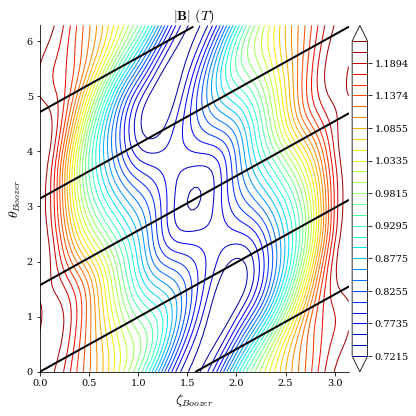

In [14]:
# defaults to the rho=1 surface
plot_boozer_surface(eq, fieldlines=4);

We can also plot the omnigenous field that was used as a target during the optimization, as shown below. 
This is a perfectly omnigenous magnetic field and is physically unrealistic to achieve by an equilibrium, but it represents the "closest" omnigenous field to the optimized solution. 
In the limit of lower omnigenity errors, this plot and the one from the equilibrium plotted above should approach becoming identical. 

Plotting the omnigenous field in Boozer coordinates requires a value for the rotational transform, so we use $\iota$ from the optimized equilibrium. 

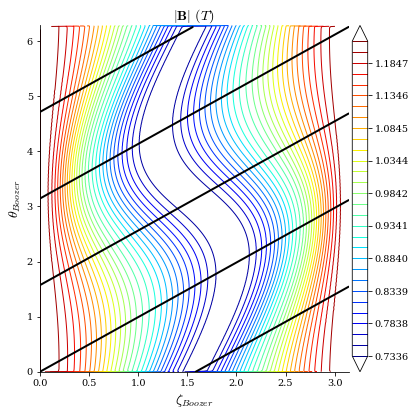

In [15]:
# compute the rotational transform at rho=1
grid = LinearGrid(M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
iota = eq.compute("iota", grid=grid)["iota"][0]

plot_boozer_surface(field, iota=iota, fieldlines=4);

It is also useful to compare the boundaries of the initial and optimized equilibria, as shown in this plot. 
This reveals that the optimization improved the omnigenity by adding some torsion and elongation. 

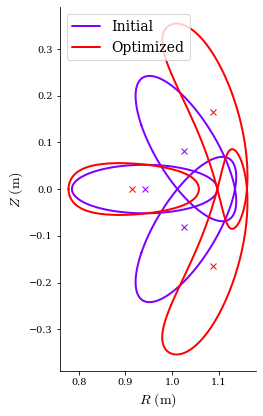

In [16]:
plot_boundaries((eq0, eq), labels=["Initial", "Optimized"], phi=3, lw=2);

We can plot the magnetic well again to see how its shape changed during the optimization. 

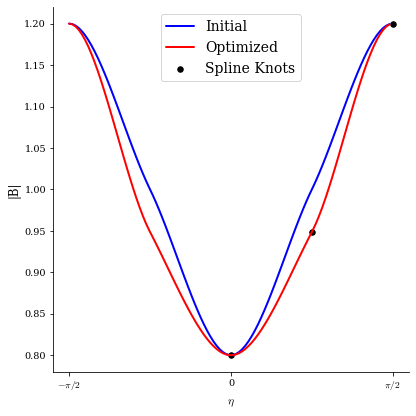

In [17]:
# plot final target well |B|
data_optimal = field.compute("|B|", grid=grid_well)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(data_initial["eta"], data_initial["|B|"], c="b", lw=2, label="Initial")
ax.plot(data_optimal["eta"], data_optimal["|B|"], c="r", lw=2, label="Optimized")
ax.scatter(
    [0, np.pi / 4, np.pi / 2],
    field.B_lm[0 : field.M_B] - field.B_lm[field.M_B :],
    c="k",
    marker=".",
    label="Spline Knots",
    s=120,
)
ax.set_xticks([-np.pi / 2, 0, np.pi / 2])
ax.set_xticklabels(["$-\\pi/2$", "0", "$\\pi/2$"])
ax.set_xlabel("$\\eta$")
ax.set_ylabel("|B|")
ax.legend(loc="upper center");

## OmnigenityHarmonics
OmnigenityHarmonics, aka OOPS (Omnigenity OPtimization like quasi-Symmetry), the detailed are described in [Liu. et al. (2024)](https://arxiv.org/abs/2502.09350). 
OOPS leverages the concept of a homeomorphism to enable the optimization of omnigenity, as well as other concepts like pseudo-symetry and piecewise omnigenity, in spectral space, analogous to the optimization of quasisymmetry. A key advantage of this method is that it is independent of any specific parameterization. One can use the Cary-Shasharina mapping [Cary;Shasharina(1997)](https://doi.org/10.1103/PhysRevLett.78.674), the Landreman-Catto mapping [Landreman;Catto(2012)](https://doi.org/10.1063/1.3693187), the current DESC mapping, or any others. It only requires a method for constructing the target magnetic field. 

First, we simply repeat the above approach, replacing `Omnigenity` with `OmnigenityHarmonics` and moving the `MirrorRatio` constraint into the equilibrium itself. When using the `OmnigenityHarmonics` method, the `OmnigenousField` only provides the shape of the target field rather than its values.

Building objective: major radius
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 16.3 ms
Building objective: omnigenity_harmonics
Precomputing transforms
Timer: Precomputing transforms = 875 ms
Building objective: omnigenity_harmonics
Precomputing transforms
Timer: Precomputing transforms = 37.5 ms
Timer: Objective build = 957 ms
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: fixed omnigenity B_max
Building objective: fixed omnigenity map
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 34.1 ms
Building objective: current density
Precomputing transforms
Timer: Precomputing transforms = 37.6 ms
Building objective: mirror ratio
Precomputing transforms
Timer: Precomputing transforms = 15.7 ms
Timer: Objec

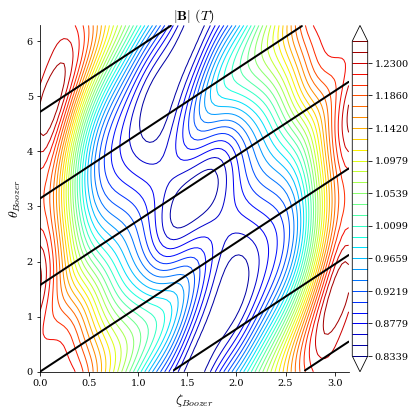

In [18]:
eq = eq0.copy()
field = field0.copy()

field_half_grid = LinearGrid(rho=0.5, M=4 * eq.M, N=4 * eq.N, NFP=field.NFP, sym=False)
field_lcfs_grid = LinearGrid(rho=1.0, M=4 * eq.M, N=4 * eq.N, NFP=field.NFP, sym=False)

objective = ObjectiveFunction(
    (
        # target major radius of R0=1 m
        GenericObjective("R0", thing=eq, target=1.0, name="major radius"),
        # target aspect ratio R0/a<=10
        AspectRatio(eq=eq, bounds=(0, 10)),
        # omnigenity on the rho=0.5 surface
        OmnigenityHarmonics(
            eq=eq,
            field=field,
            field_type="desc",  # 'desc' or 'lcform' or 'oops', depend on which field class is used
            eq_grid=eq_half_grid,
            field_grid=field_half_grid,
            M_harmonics=16,
            N_harmonics=8,
        ),
        # omnigenity on the rho=1.0 surface
        OmnigenityHarmonics(
            eq=eq,
            field=field,
            field_type="desc",  # 'desc' or 'lcform' or 'oops', depend on which field class is used
            eq_grid=eq_lcfs_grid,
            field_grid=field_lcfs_grid,
            M_harmonics=16,
            N_harmonics=8,
        ),
    )
)

constraints = (
    CurrentDensity(eq=eq),  # vacuum equilibrium force balance
    FixPressure(eq=eq),  # fix vacuum pressure profile
    FixCurrent(eq=eq),  # fix vacuum current profile
    FixPsi(eq=eq),  # fix total toroidal magnetic flux
    # ensure the B_max contour is straight in Boozer coordinates
    FixOmniBmax(field=field),
    # ensure the average B_min contour is at zeta_B=pi/NFP
    FixOmniMap(field=field, indices=np.where(field.x_basis.modes[:, 1] == 0)[0]),
    # fix the mirror ratio on the magnetic axis
    MirrorRatio(eq=eq, target=(1.2 - 0.8) / (1.2 + 0.8)),
)
optimizer = Optimizer("lsq-auglag")
(eq, field), _ = optimizer.optimize(
    (eq, field), objective, constraints, maxiter=100, verbose=3
)
eq, _ = eq.solve(objective="force", verbose=3)
plot_boozer_surface(eq, fieldlines=4);

## Other Omnigenous Field Example
`OmnigenousFieldOOPS` and `OmnigenousLCForm` use the `S` and `D` functions to parameterize the Cary-Shasharina mapping, with the detailed formulation given in [Landreman,Catto(2012)](https://doi.org/10.1063/1.3693187) or [Liu. et al. (2024)](https://arxiv.org/abs/2502.09350). Unlike `OmnigenousField`, which offers extremely high flexibility, these two methods are better suited for prescribing specific contour distributions, thus providing an advantage in terms of intuition and interpretability. `OmnigenousFieldOOPS` defines a class of stellarator-symmetric mappings on a single flux surface, parameterized by the degrees of freedom `S_list` and `D_list`. `OmnigenousFieldLCForm`, on the other hand, follows the Landreman–Catto mapping form, allowing the user to specify `S_func` and `D_func`, as well as the way in which `S_list` and `D_list` are assigned as degrees of freedom. This approach supports both stellarator-symmetric and partially non–stellarator-symmetric mappings on a single flux surface.

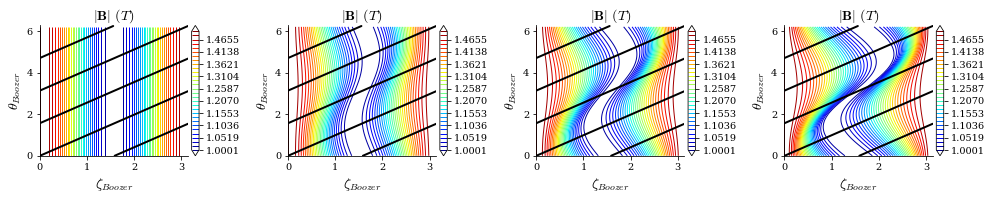

In [19]:
s_values = np.array([0.0, 0.1, 0.2, 0.3])
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
for ax, s in zip(ax, s_values):
    field_oops = OmnigenousFieldOOPS(
        S_len=1,
        D_len=1,
        NFP=eq.NFP,  # number of field periods; should always be equal to Equilibrium.NFP
        helicity=(0, 1),  # helicity, no need mulitpy by NFP
        S_list=np.array([s]),  # S function coefficents
        D_list=np.array([1]),  # D function coefficents
    )
    plot_boozer_surface(field_oops, iota=iota, fieldlines=4, ax=ax);

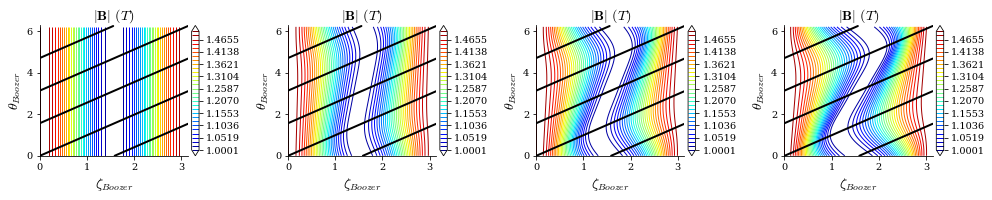

In [20]:
def _S_func(x2d, y2d, S_list):
    S = S_list[0] * (x2d) * jnp.sin(y2d + S_list[1] * jnp.sin(y2d))
    return S


def _D_func(x2d, D_list):
    p = D_list[0]
    a = jnp.clip(np.pi - x2d, 0, np.pi)  # make AD
    D = (np.pi ** (p - 1)) ** (1 / p) * (a) ** (1 / p)
    return D


fig, ax = plt.subplots(1, 4, figsize=(14, 3))
for ax, s in zip(ax, s_values):
    field_lcform = OmnigenousFieldLCForm(
        S_len=2,
        D_len=1,
        NFP=eq.NFP,  # number of field periods; should always be equal to Equilibrium.NFP
        helicity=(0, 1),  # helicity, no need mulitpy by NFP
        S_list=np.array([s, 0.4]),  # S function coefficents
        D_list=np.array([1]),  # D function coefficents
        S_func=_S_func,
        D_func=_D_func,
    )
    plot_boozer_surface(field_lcform, iota=iota, fieldlines=4, ax=ax);

## Precisely Poloidal Omnigenity
The following script demonstrates how to use the resolution-increase method (referred in SIMSOPT), also known as multigrid (reffered in DESC), in a way similar to QS optimization, starting from a circular cross-section torus and optimizing step by step toward a high-resolution poloidal-omnigenous (PO) configuration.

In [21]:
from desc.continuation import solve_continuation_automatic

surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.15],
    Z_lmn=[-0.15],
    modes_R=[[0, 0], [1, 0]],
    modes_Z=[[-1, 0]],
    NFP=3,
)

M = 13
N = 13

eq = Equilibrium(
    M=3, N=3, M_grid=2 * M, N_grid=2 * N, L=3, L_grid=12, Psi=8.3e-2, surface=surf
)
eq0 = solve_continuation_automatic(eq, verbose=0)[-1]
eqfam = EquilibriaFamily(eq0)

Lets look at the initial field:

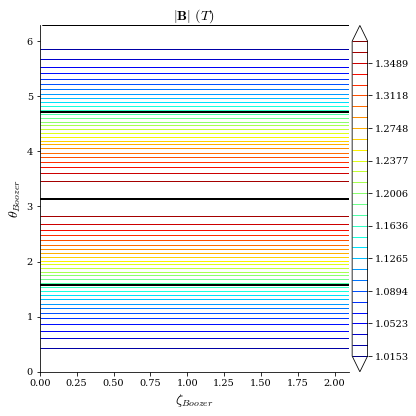

In [22]:
plot_boozer_surface(eq0, fieldlines=4, ncontours=30);

In [23]:
field = OmnigenousFieldOOPS(
    S_len=1,
    D_len=1,
    NFP=eq.NFP,
    helicity=(0, 1),
    S_list=np.array([0.3]),
    D_list=np.array([0]),
)

eq_lcfs_grid = LinearGrid(rho=1.0, M=4 * M, N=4 * N, NFP=eq.NFP, sym=False)
field_lcfs_grid = LinearGrid(rho=1.0, theta=191, zeta=191, NFP=field.NFP, sym=False)
iota_grid = LinearGrid(
    rho=jnp.linspace(0, 1, 10), M=4 * M, N=4 * N, NFP=eq.NFP, sym=False
)

max_mode = jnp.array([3, 4, 5, 7, 8, 10, 13, 13])
l_mode = jnp.array([3, 3, 3, 4, 4, 4, 5, 5, 6])


def run_po_step(k, eq):
    print("Optimizing for k = {}".format(k))
    objective = ObjectiveFunction(
        (
            AspectRatio(eq=eq, target=6.5),
            OmnigenityHarmonics(
                eq=eq,
                field=field,
                field_type="oops",
                eq_grid=eq_lcfs_grid,
                field_grid=field_lcfs_grid,
                M_harmonics=80,
                N_harmonics=80,
                field_fixed=True,  # We fix it
            ),
            RotationalTransform(
                eq=eq,
                grid=LinearGrid(rho=[1], M=4 * M, N=4 * N, NFP=eq.NFP, sym=False),
                target=jnp.array([0.76]),
                normalize=False,
            ),
        )
    )
    R_modes = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]

    constraints = (
        ForceBalance(eq=eq),  # vacuum equilibrium force balance
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),  # fix vacuum pressure profile
        FixCurrent(eq=eq),  # fix vacuum current profile
        FixPsi(eq=eq),  # fix total toroidal magnetic flux
    )

    optimizer = Optimizer("lsq-exact")
    (eq_new,), _ = optimizer.optimize(
        (eq,),
        objective,
        constraints,
        maxiter=100,
        verbose=3,
        copy=True,
    )
    # Through we choose proximal-lsqexact, we still need equilibrium to be force balanced at higher resolution
    eq_new.change_resolution(M=max_mode[k], N=max_mode[k], L=l_mode[k])
    eq_new, _ = eq_new.solve(objective="force", verbose=3)

    return eq_new

We decide to fix the target field in order to obtain the closest possible configuration. Here we present our initial field. It should be noted that the magnetic field strength shown here is virtual, serving only as a demonstration with emphasis on the contours.

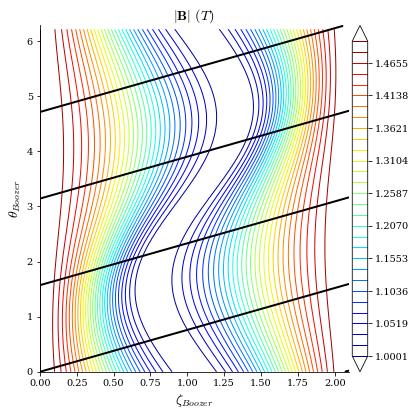

In [30]:
plot_boozer_surface(field, iota=0.76, fieldlines=4, ncontours=30);

Now let’s run the optimization in steps and look at the intermediate result after each step:

Optimizing for k = 1


/home/hengqianliu/Documents/desc_develop/omnigenity/DESC-OOPS/desc/optimize/optimizer.py:455: FutureWarning: 
                Nonlinear constraints detected but method lsq-exact does not support
                nonlinear constraints. Defaulting to method "proximal-lsq-exact"
                In the future this will raise an error. To ignore this warning, specify
                a wrapper "proximal-" to convert the nonlinearly constrained problem
                into an unconstrained one.
                
  warnings.warn(


Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 18.0 ms
Building objective: omnigenity_harmonics
Precomputing transforms
Timer: Precomputing transforms = 1.30 sec
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 17.0 ms
Timer: Objective build = 1.38 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 38.7 ms
Timer: Objective build = 48.2 ms
Timer: Objective build = 841 us
Timer: Eq Update LinearConstraintProjection build = 16.7 ms
Timer: Proximal projection build = 2.23 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 342 ms
Timer: LinearConstraintProjection build = 1.24 sec
Number of parameters: 8
Number of objectives: 12882
Timer: Initializing the optimization = 3.87 sec

Starting optimization
Using method: lsq-exact
   Iteration

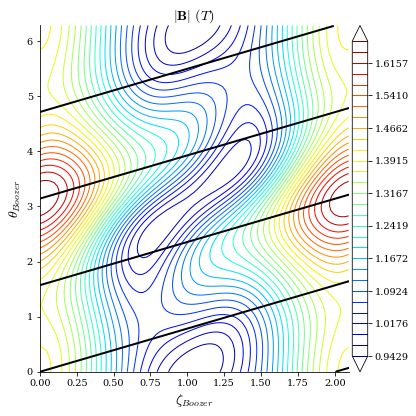

In [24]:
eq1 = run_po_step(1, eq0)
eqfam.append(eq1)
plot_boozer_surface(eq1, fieldlines=4, ncontours=30);

Optimizing for k = 2


/home/hengqianliu/Documents/desc_develop/omnigenity/DESC-OOPS/desc/optimize/optimizer.py:455: FutureWarning: 
                Nonlinear constraints detected but method lsq-exact does not support
                nonlinear constraints. Defaulting to method "proximal-lsq-exact"
                In the future this will raise an error. To ignore this warning, specify
                a wrapper "proximal-" to convert the nonlinearly constrained problem
                into an unconstrained one.
                
  warnings.warn(


Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 428 ms
Building objective: omnigenity_harmonics
Precomputing transforms
Timer: Precomputing transforms = 309 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 18.0 ms
Timer: Objective build = 767 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 39.5 ms
Timer: Objective build = 49.3 ms
Timer: Objective build = 865 us
Timer: Eq Update LinearConstraintProjection build = 18.8 ms
Timer: Proximal projection build = 1.48 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 340 ms
Timer: LinearConstraintProjection build = 1.05 sec
Number of parameters: 24
Number of objectives: 12882
Timer: Initializing the optimization = 2.93 sec

Starting optimization
Using method: lsq-exact
   Iteration    

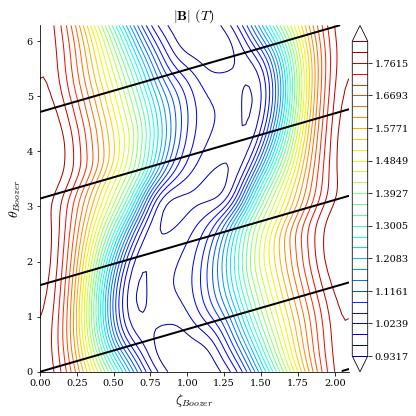

In [25]:
eq2 = run_po_step(2, eq1)
eqfam.append(eq2)
plot_boozer_surface(eq2, fieldlines=4, ncontours=30);

Optimizing for k = 3


/home/hengqianliu/Documents/desc_develop/omnigenity/DESC-OOPS/desc/optimize/optimizer.py:455: FutureWarning: 
                Nonlinear constraints detected but method lsq-exact does not support
                nonlinear constraints. Defaulting to method "proximal-lsq-exact"
                In the future this will raise an error. To ignore this warning, specify
                a wrapper "proximal-" to convert the nonlinearly constrained problem
                into an unconstrained one.
                
  warnings.warn(


Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 439 ms
Building objective: omnigenity_harmonics
Precomputing transforms
Timer: Precomputing transforms = 303 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 17.8 ms
Timer: Objective build = 772 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 40.0 ms
Timer: Objective build = 50.0 ms
Timer: Objective build = 819 us
Timer: Eq Update LinearConstraintProjection build = 24.9 ms
Timer: Proximal projection build = 1.45 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 229 ms
Timer: LinearConstraintProjection build = 1.27 sec
Number of parameters: 48
Number of objectives: 12882
Timer: Initializing the optimization = 3.02 sec

Starting optimization
Using method: lsq-exact
   Iteration    

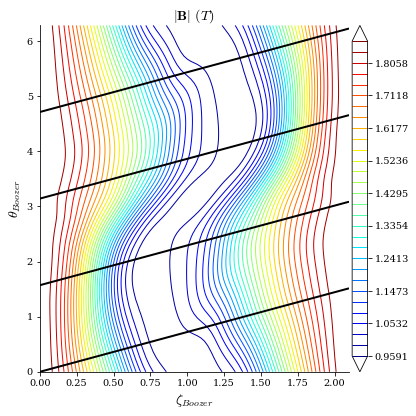

In [26]:
eq3 = run_po_step(3, eq2)
eqfam.append(eq3)
plot_boozer_surface(eq3, fieldlines=4, ncontours=30);

Optimizing for k = 4


/home/hengqianliu/Documents/desc_develop/omnigenity/DESC-OOPS/desc/optimize/optimizer.py:455: FutureWarning: 
                Nonlinear constraints detected but method lsq-exact does not support
                nonlinear constraints. Defaulting to method "proximal-lsq-exact"
                In the future this will raise an error. To ignore this warning, specify
                a wrapper "proximal-" to convert the nonlinearly constrained problem
                into an unconstrained one.
                
  warnings.warn(


Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 441 ms
Building objective: omnigenity_harmonics
Precomputing transforms
Timer: Precomputing transforms = 317 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 18.8 ms
Timer: Objective build = 788 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 41.5 ms
Timer: Objective build = 51.3 ms
Timer: Objective build = 853 us
Timer: Eq Update LinearConstraintProjection build = 80.5 ms
Timer: Proximal projection build = 2.32 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 367 ms
Timer: LinearConstraintProjection build = 1.35 sec
Number of parameters: 80
Number of objectives: 12882
Timer: Initializing the optimization = 4.10 sec

Starting optimization
Using method: lsq-exact
   Iteration    

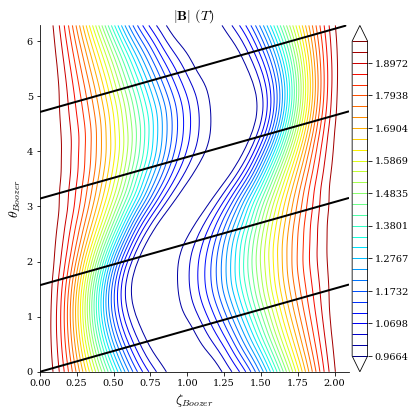

In [27]:
eq4 = run_po_step(4, eq3)
eqfam.append(eq4)
plot_boozer_surface(eq4, fieldlines=4, ncontours=30);

One can gradually increase the mode numbers to obtain a more refined equilibrium. Alternatively, the fraction of trapped particles can be reduced by constraining the mirror ratio. Another option is to use this configuration as an initial condition, then relax the mapping degrees of freedom to accommodate trade-offs in multi-objective optimization. Finally, let us take a look at the boundary shape.

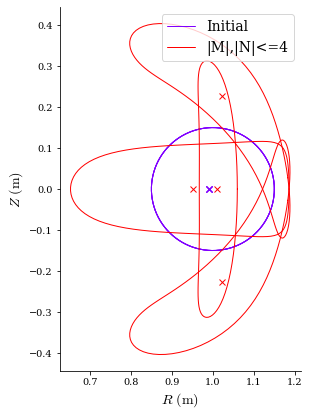

In [28]:
plot_boundaries([eq0, eqfam[-1]], labels=["Initial", "|M|,|N|<=4"]);